# DC House Price 

#### Data source: https://www.redfin.com/blog/data-center

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Import and Data Cleaning
### Importing data and creating dataframes for each Washington DC region
#### All required dataset are downloaded in data folder

In [2]:
# set up name lable to match each csv dataset
lst = []
for i in range(1,83):
    location = 'data/'
    ext = 'data_crosstab ({}).csv'.format(i)
    final = location + ext
    lst.append(final)
    # print(final)

# pull datasets from data folder and clean data such as $1,200K, 1.5%, etc. Change data type from object to float
# create a new list: df_list to include all datasets
df_list = []
i = 0
for location in lst:
    df = pd.read_csv(location, encoding='utf-16', sep='\t')
    df = df.add_suffix('_'+str(i))
    # reformat the median sale prices from strings to floats
    #df["Median Sale Price" + "_"+ str(i)] = df["Median Sale Price" + "_"+ str(i)].str.replace("$", "").str.replace(",", "").str.replace("K","000").str.replace("%","").astype(float)
    for j in range(len(df.columns)-2):
        if df[df.columns[j+2]].dtype == 'object':
            df[df.columns[j+2]] = df[df.columns[j+2]].str.replace("$", "").str.replace(",", "").str.replace("K","000").str.replace("%","").astype(float)
        #df[df.columns[j+2]] = df[df.columns[j+2]].str.replace("$", "").str.replace(",", "").str.replace("K","000").str.replace("%","").astype(float)
    df_list.append(df)
    i += 1
# df_list[0].head()

In [3]:
# review the colnum names 
df.columns

Index(['Region_81', 'Month of Period End_81', 'Median Sale Price_81',
       'Median Sale Price MoM _81', 'Median Sale Price YoY _81',
       'Homes Sold_81', 'Homes Sold MoM _81', 'Homes Sold YoY _81',
       'New Listings_81', 'New Listings MoM _81', 'New Listings YoY _81',
       'Inventory_81', 'Inventory MoM _81', ' Inventory YoY _81',
       'Days on Market_81', 'Days on Market MoM_81', 'Days on Market YoY_81',
       'Average Sale To List_81', 'Average Sale To List MoM _81',
       'Average Sale To List YoY _81'],
      dtype='object')

In [4]:
# Ensure the data type is appropriate for analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 20 columns):
Region_81                       94 non-null object
Month of Period End_81          94 non-null object
Median Sale Price_81            94 non-null float64
Median Sale Price MoM _81       94 non-null float64
Median Sale Price YoY _81       94 non-null float64
Homes Sold_81                   94 non-null int64
Homes Sold MoM _81              94 non-null float64
Homes Sold YoY _81              94 non-null float64
New Listings_81                 94 non-null int64
New Listings MoM _81            94 non-null float64
New Listings YoY _81            94 non-null float64
Inventory_81                    94 non-null int64
Inventory MoM _81               94 non-null float64
 Inventory YoY _81              94 non-null float64
Days on Market_81               94 non-null int64
Days on Market MoM_81           94 non-null int64
Days on Market YoY_81           94 non-null int64
Average Sale To List_81    

### Creating dataframe containing median sale prices, Homes Sold MoM and Inventory MoM of each Washington DC region from Feb. 2012 to Oct. 2019 

In [5]:
# Datasets for median sale prices, Homes Sold MoM and Inventory MoM are saved in data folder

final_lst = []
i = 0
for df in df_list:
    final_lst.append(df["Median Sale Price" + "_"+ str(i)][0:93])
    i += 1
A = pd.concat(final_lst, axis = 1)
A.to_csv('data/Median Sale Price.csv')
#Creating dataframe containing homes sold MoM of each Washington DC region from Feb. 2012 to Oct. 2019 
final_lst_2 = []
i = 0
for df in df_list:
    final_lst_2.append(df["Homes Sold MoM " + "_"+ str(i)][0:93])
    i += 1
B = pd.concat(final_lst_2, axis = 1)
B.to_csv('data/Homes Sold MoM.csv')
#Creating dataframe containing inventory MoM of each Washington DC region from Feb. 2012 to Oct. 2019 
final_lst_3 = []
i = 0
for df in df_list:
    final_lst_3.append(df["Inventory MoM " + "_"+ str(i)][0:93])
    i += 1
C = pd.concat(final_lst_3, axis = 1)
C.to_csv('data/Inventory MoM.csv')

In [8]:
A
B
C

,Inventory MoM _0,Inventory MoM _1,Inventory MoM _2,Inventory MoM _3,Inventory MoM _4,Inventory MoM _5,Inventory MoM _6,Inventory MoM _7,Inventory MoM _8,Inventory MoM _9,...,Inventory MoM _72,Inventory MoM _73,Inventory MoM _74,Inventory MoM _75,Inventory MoM _76,Inventory MoM _77,Inventory MoM _78,Inventory MoM _79,Inventory MoM _80,Inventory MoM _81
0,-6.7,4.2,-17.4,33.3,6.7,-3.3,12.3,33.3,-7.1,6.3,...,-25.0,4.3,0.0,NaN,3.7,0.0,6.5,16.0,60.0,-12.5
1,7.1,12.0,0.0,-25.0,12.5,0.0,3.7,15.0,-30.8,17.6,...,45.8,25.0,-14.3,NaN,28.6,4.5,3.0,0.0,37.5,-9.5
2,-5.6,7.1,15.8,16.7,-27.8,-5.1,7.1,-4.3,66.7,-25.0,...,-20.0,7.8,-16.7,33.3,-5.6,-8.7,-26.5,10.3,-9.1,10.5
3,3.5,-13.3,-22.7,-42.9,7.7,12.5,-17.6,-27.3,-6.7,6.7,...,3.6,-3.1,40.0,50.0,-11.8,4.8,16.0,3.1,-20.0,4.8
4,3.4,-7.7,0.0,50.0,7.1,7.9,9.3,12.5,21.4,0.0,...,17.2,-2.1,-28.6,-66.7,0.0,-4.5,3.4,0.0,-12.5,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,4.5,-32.0,28.6,50.0,16.7,15.2,-17.3,-29.2,57.1,21.4,...,4.3,7.6,57.1,-50.0,43.5,40.0,19.0,20.0,-44.4,3.3
89,0.0,-5.9,0.0,0.0,-14.3,-18.9,7.0,-11.8,-36.4,-11.8,...,-10.2,-11.1,-9.1,100.0,-30.3,-28.6,0.0,4.2,30.0,-9.7
90,-11.4,-6.3,55.6,-66.7,-41.7,-14.0,2.2,0.0,-14.3,-26.7,...,-31.8,18.2,-80.0,-50.0,26.1,0.0,-6.0,-16.0,-15.4,0.0
91,21.0,60.0,28.6,0.0,28.6,27.0,-8.5,20.0,50.0,18.2,...,83.3,37.5,350.0,0.0,3.4,0.0,-2.1,42.9,45.5,42.9


#### Median Sale Price Hypothesis Tests

In [9]:
# A is the final dataset(panda.dataframe) with only median sale price for each region. Say n regions
# Create a list combine_list containing any two regions out of n region: list(itertools.combinations(range(A.shape[1]), 2))
# Run a loop to perform hypothesis testings: T test, Wilcoxon test, KS test, Mann-Whitney rank test 

import itertools
from statsmodels.stats.weightstats import ttest_ind as t_test
from scipy.stats import wilcoxon
from scipy.stats import ks_2samp 
from scipy.stats import mannwhitneyu

 
combine_list = list(itertools.combinations(range(A.shape[1]), 2))
#statistic, p-value, degree of freedom for two-sample t test
t_stat = []
p_val_t = []
df = []

# statistic and p-value for Wilcoxon test 
non_stat = []
p_val_wc = []

# statistic and p-value for KS test 
ks_stat = []
p_val_ks = []

# statistic and p-value for Mann-Whitney rank test  test 
mu_stat = []
p_val_mu = []

for i in range(len(combine_list)):
    temp1, temp2, temp3 = t_test(A.iloc[:,combine_list[i][0]], A.iloc[:,combine_list[i][1]], alternative = "two-sided", usevar = "unequal")
    t_stat.append(float(temp1)) 
    p_val_t.append(float(temp2))
    df.append(float(temp3))
    temp4, temp5 = wilcoxon(A.iloc[:,combine_list[i][0]], A.iloc[:,combine_list[i][1]], alternative = "two-sided", zero_method = "zsplit")
    non_stat.append(float(temp4))
    p_val_wc.append(float(temp5)) 
    temp6, temp7 = ks_2samp(A.iloc[:,combine_list[i][0]], A.iloc[:,combine_list[i][1]], alternative = "two-sided", mode = 'asymp')
    ks_stat.append(float(temp6))
    p_val_ks.append(float(temp7))
    temp8, temp9 = mannwhitneyu(A.iloc[:,combine_list[i][0]], A.iloc[:,combine_list[i][1]], alternative = "two-sided")
    mu_stat.append(float(temp8))
    p_val_mu.append(float(temp9))

test_matrix = pd.DataFrame(list(zip(combine_list, t_stat, p_val_t, df, non_stat, p_val_wc, ks_stat, p_val_ks, mu_stat, p_val_mu)), 
               columns =['combinatory', 'Stat_ttest', 'p_ttest', 'df_ttest', 'Stat_wctest', 'p_wctest', 'Stat_kstest', 'p_kstest', 'Stat_mutest', 'p_mutest'])

In [10]:
test_matrix

,combinatory,Stat_ttest,p_ttest,df_ttest,Stat_wctest,p_wctest,Stat_kstest,p_kstest,Stat_mutest,p_mutest
0,"(0, 1)",-44.211365,1.392565e-92,162.733911,0.0,5.565426e-17,1.000000,8.159117e-41,0.0,5.023770e-32
1,"(0, 2)",22.639833,9.024331e-49,140.788533,0.0,5.562522e-17,0.924731,5.793541e-35,8619.0,1.320081e-31
2,"(0, 3)",-35.756287,2.704627e-67,124.381542,0.0,5.567241e-17,1.000000,8.159117e-41,0.0,5.019844e-32
3,"(0, 4)",32.808925,1.959838e-75,169.926156,0.0,5.562159e-17,1.000000,8.159117e-41,8649.0,5.025079e-32
4,"(0, 5)",30.579648,2.762020e-67,153.930360,0.0,5.562522e-17,1.000000,8.159117e-41,8649.0,5.014940e-32
...,...,...,...,...,...,...,...,...,...,...
3316,"(78, 80)",-1.194416,2.342584e-01,145.523201,2029.5,5.500174e-01,0.236559,1.098577e-02,4399.5,8.391812e-01
3317,"(78, 81)",10.479537,1.445043e-19,147.984082,39.0,1.956860e-16,0.752688,2.623298e-23,8024.5,6.933220e-24
3318,"(79, 80)",14.377349,1.287231e-31,178.194568,24.0,1.210574e-16,0.763441,5.759717e-24,7987.5,1.928951e-23
3319,"(79, 81)",30.080162,9.041485e-58,120.159329,0.0,5.569784e-17,1.000000,8.159117e-41,8649.0,5.029665e-32


In [11]:
# Create a function to detect the hypothesis testing results. 0: reject null, 1: fail to reject null
def test_p_value(p = .05, name = 'ttest'):
    name_list = []
    for i in range(len(test_matrix)):
        if test_matrix["p_" + name][i] < p:
            name_list.append(0) 
        else:
            name_list.append(1)   
    test_matrix['index_' + name] = name_list

In [12]:
test_p_value(p = .05, name = 'ttest')
test_p_value(p = .05, name = 'wctest')
test_p_value(p = .05, name = 'kstest')
test_p_value(p = .05, name = 'mutest')
#test_matrix
#test_matrix.shape

In [13]:
# Save the final testing results in data folder
test_matrix.to_csv('data/TM_Median Sale Price.csv')

In [14]:
# Find all regions with similar characteristic based on both Wilcoxon and Mann Whitney tests
index_wc = test_matrix['index_wctest'] == 1
index_mu = test_matrix['index_mutest'] == 1
#test_matrix[index_wc]
#test_matrix[index_mu]
test_matrix[index_wc & index_mu]

,combinatory,Stat_ttest,p_ttest,df_ttest,Stat_wctest,p_wctest,Stat_kstest,p_kstest,Stat_mutest,p_mutest,index_ttest,index_wctest,index_kstest,index_mutest
63,"(0, 64)",-1.100723,0.272827,146.133072,1840.5,0.186183,0.258065,0.004085,3617.5,0.054263,1,1,0,1
97,"(1, 18)",-0.252229,0.801153,178.930848,2103.5,0.753364,0.096774,0.776502,4258.5,0.858388,1,1,1,1
114,"(1, 35)",-1.740196,0.084556,112.627515,2110.5,0.773827,0.182796,0.089415,4204.0,0.743749,1,1,1,1
144,"(1, 65)",0.400265,0.689441,178.017268,1945.0,0.356764,0.086022,0.881527,4451.5,0.730399,1,1,1,1
188,"(2, 30)",1.238531,0.217345,158.964615,1721.5,0.075412,0.301075,0.000436,4756.5,0.239824,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299,"(74, 81)",-0.200389,0.841430,160.371280,2118.0,0.795916,0.225806,0.017443,4040.0,0.439149,1,1,0,1
3306,"(76, 77)",-0.128037,0.898269,172.233319,2131.5,0.836077,0.182796,0.089415,4585.0,0.478771,1,1,1,1
3310,"(76, 81)",1.407618,0.161255,154.322351,1785.5,0.125351,0.204301,0.041230,4504.0,0.625811,1,1,0,1
3314,"(77, 81)",1.387637,0.166993,176.917092,1705.5,0.065882,0.161290,0.177833,4446.0,0.741693,1,1,1,1


In [15]:
df_list[1]['Region_1'][0]

'Washington, DC - American University Park / Friendship Heights / Tenleytown'

In [16]:
df_list[18]['Region_18'][0]

'Washington, DC - Chevy Chase-DC'

In [17]:
df_list[35]['Region_35'][0]

'Washington, DC - Foxhall Village'

In [18]:
df_list[65]['Region_65'][0]

'Washington, DC - Southeast Chevy Chase'

In [19]:
# Set up data time frame
time_frame = pd.date_range('2012-02-01','2019-10-01', 
              freq='MS').strftime("%Y-%b").tolist()

In [25]:
df_temp = pd.DataFrame(list(zip(time_frame, A['Median Sale Price_0'], A['Median Sale Price_1'], A['Median Sale Price_2'], A['Median Sale Price_3'], A['Median Sale Price_4'], A['Median Sale Price_5'], A['Median Sale Price_6'],A['Median Sale Price_7'])), 
               columns =['Time', df_list[0]['Region_0'][0], df_list[1]['Region_1'][0], df_list[2]['Region_2'][0], df_list[3]['Region_3'][0], df_list[4]['Region_4'][0], df_list[5]['Region_5'][0], df_list[6]['Region_6'][0], df_list[7]['Region_7'][0]])

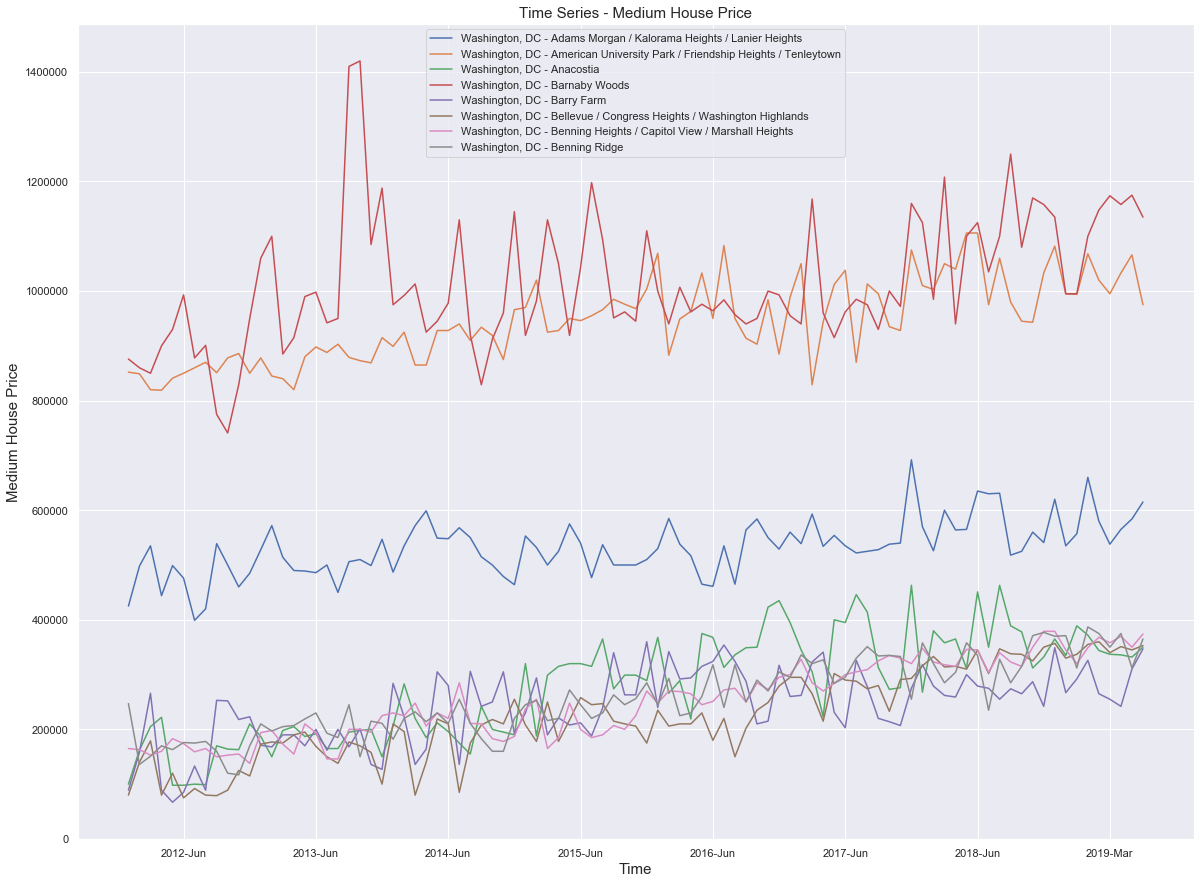

In [28]:
# plot 
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,1], label = df_temp.columns[1])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,2], label = df_temp.columns[2])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,3], label = df_temp.columns[3])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,4], label = df_temp.columns[4])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,5], label = df_temp.columns[5])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,6], label = df_temp.columns[6])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,7], label = df_temp.columns[7])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,8], label = df_temp.columns[8])


plt.legend()
plt.title("Time Series - Medium House Price",fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Medium House Price", fontsize = 15)
sns.set(rc={'figure.figsize':(30,20)})
plt.xticks(range(5, 100, 12))
#plt.xlim()
plt.show()
sns_plot.figure.savefig("Time Series - Medium House Price.png")

In [29]:
time_frame = pd.date_range('2012-02-01','2019-10-01', 
              freq='MS').strftime("%Y-%b").tolist()
df_temp = pd.DataFrame(list(zip(time_frame, A['Median Sale Price_1'], A['Median Sale Price_18'], A['Median Sale Price_35'], A['Median Sale Price_65'])), 
               columns =['Time', df_list[1]['Region_1'][0], df_list[18]['Region_18'][0], df_list[35]['Region_35'][0], df_list[65]['Region_65'][0]])
#df_temp1 = df_temp.set_index(df['Time'])

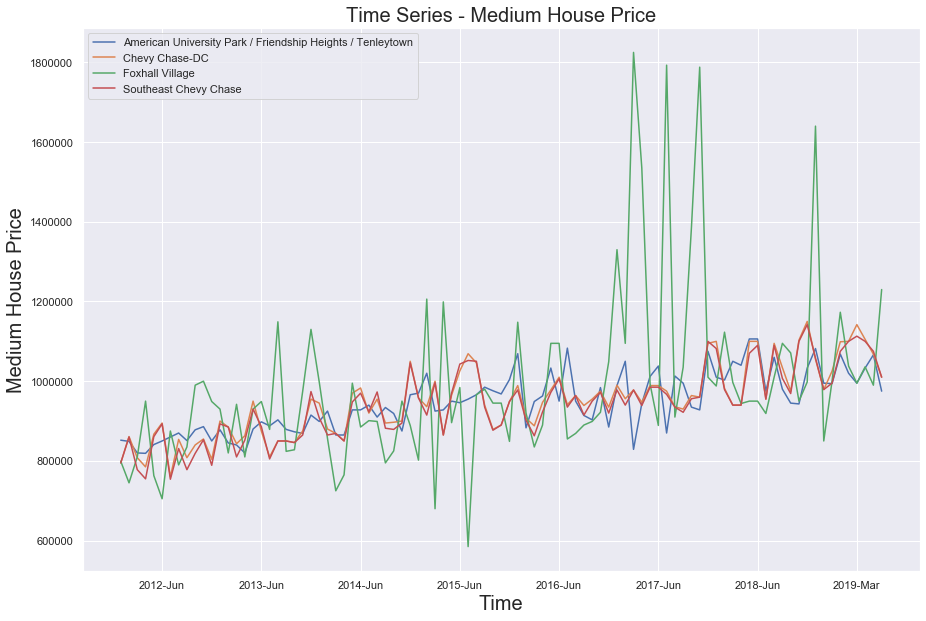

In [31]:
# plot 
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,1], label = 'American University Park / Friendship Heights / Tenleytown')
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,2], label = 'Chevy Chase-DC')
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,3], label = 'Foxhall Village')
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,4], label = 'Southeast Chevy Chase')

plt.legend()
plt.title("Time Series - Medium House Price",fontsize = 20)
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Medium House Price", fontsize = 20)
sns.set(rc={'figure.figsize':(15,10)})
plt.xticks(range(5, 100, 12))
#plt.xlim()
plt.show()
sns_plot.figure.savefig("Time Series - Medium House Price_Group.png")

#### Homes Sold MoM Hypothesis Tests

In [32]:
# B is the final dataset(panda.dataframe) with only homes sold MoM for each region. Say n regions
# Create a list combine_list containing any two regions out of n region: list(itertools.combinations(range(A.shape[1]), 2))
# Run a loop to perform hypothesis testings: T test, Wilcoxon test, KS test, Mann-Whitney rank test 

import itertools
from statsmodels.stats.weightstats import ttest_ind as t_test
from scipy.stats import wilcoxon
from scipy.stats import ks_2samp 
from scipy.stats import mannwhitneyu

combine_list = list(itertools.combinations(range(B.shape[1]), 2))

#statistic, p-value, degree of freedom for two-sample t test
t_stat = []
p_val_t = []
df = []

# statistic and p-value for Wilcoxon test 
non_stat = []
p_val_wc = []

# statistic and p-value for KS test 
ks_stat = []
p_val_ks = []

# statistic and p-value for Mann-Whitney rank test  test 
mu_stat = []
p_val_mu = []

for i in range(len(combine_list)):
    temp1, temp2, temp3 = t_test(B.iloc[:,combine_list[i][0]], B.iloc[:,combine_list[i][1]], alternative = "two-sided", usevar = "unequal")
    t_stat.append(float(temp1)) 
    p_val_t.append(float(temp2))
    df.append(float(temp3))
    temp4, temp5 = wilcoxon(B.iloc[:,combine_list[i][0]], B.iloc[:,combine_list[i][1]], alternative = "two-sided", zero_method = "zsplit")
    non_stat.append(float(temp4))
    p_val_wc.append(float(temp5)) 
    temp6, temp7 = ks_2samp(B.iloc[:,combine_list[i][0]], B.iloc[:,combine_list[i][1]], alternative = "two-sided", mode = 'asymp')
    ks_stat.append(float(temp6))
    p_val_ks.append(float(temp7))
    temp8, temp9 = mannwhitneyu(B.iloc[:,combine_list[i][0]], B.iloc[:,combine_list[i][1]], alternative = "two-sided")
    mu_stat.append(float(temp8))
    p_val_mu.append(float(temp9))

test_matrix_2 = pd.DataFrame(list(zip(combine_list, t_stat, p_val_t, df, non_stat, p_val_wc, ks_stat, p_val_ks, mu_stat, p_val_mu)), 
               columns =['combinatory', 'Stat_ttest', 'p_ttest', 'df_ttest', 'Stat_wctest', 'p_wctest', 'Stat_kstest', 'p_kstest', 'Stat_mutest', 'p_mutest'])

/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/morestats.py:2866: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/Users/cslsh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/morestats.py:2867: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


In [33]:
test_matrix_2

,combinatory,Stat_ttest,p_ttest,df_ttest,Stat_wctest,p_wctest,Stat_kstest,p_kstest,Stat_mutest,p_mutest
0,"(0, 1)",-0.575799,0.565624,148.242561,2073.0,0.666427,0.150538,0.242640,4435.5,0.763411
1,"(0, 2)",-1.165239,0.246232,120.072994,1989.0,0.451501,0.150538,0.242640,4371.5,0.899159
2,"(0, 3)",-1.437349,0.153796,98.259635,2011.0,0.503741,0.258065,0.004085,4448.0,0.737469
3,"(0, 4)",-1.643313,0.103096,113.072931,1967.5,0.403554,0.247312,0.006772,4278.0,0.900264
4,"(0, 5)",-0.357912,0.720828,180.417773,2032.5,0.557717,0.107527,0.655429,4194.0,0.723249
...,...,...,...,...,...,...,...,...,...,...
3316,"(78, 80)",-0.068512,0.945455,177.360534,2105.5,0.759202,0.075269,0.954821,4373.5,0.894866
3317,"(78, 81)",0.166414,0.868020,177.251494,2149.0,0.888775,0.139785,0.323565,4227.0,0.791554
3318,"(79, 80)",-0.147620,0.882807,180.650459,2122.5,0.809252,0.075269,0.954821,4285.0,0.915343
3319,"(79, 81)",0.063315,0.949588,173.086399,2148.0,0.885749,0.118280,0.533508,4164.5,0.663752


In [34]:
test_matrix_2['p_ttest'][0]

0.5656239740981964

In [35]:
# Create a function to detect the hypothesis testing results. 0: reject null, 1: fail to reject null
def test_p_value_2(p = .05, name = 'ttest'):
    name_list = []
    for i in range(len(test_matrix_2)):
        if test_matrix_2["p_" + name][i] < p:
            name_list.append(0) 
        else:
            name_list.append(1)   
    test_matrix_2['index_' + name] = name_list

In [36]:
test_p_value_2(p = .05, name = 'ttest')
test_p_value_2(p = .05, name = 'wctest')
test_p_value_2(p = .05, name = 'kstest')
test_p_value_2(p = .05, name = 'mutest')
#(test_matrix_2.index_wctest == 1)

In [37]:
# Save the final testing results in data folder
test_matrix_2.to_csv('data/TM_Homes Sold MoM.csv')

In [43]:
time_frame = pd.date_range('2012-02-01','2019-10-01', 
              freq='MS').strftime("%Y-%b").tolist()
df_temp = pd.DataFrame(list(zip(time_frame, B['Homes Sold MoM _1'], B['Homes Sold MoM _2'], B['Homes Sold MoM _3'], B['Homes Sold MoM _3'], B['Homes Sold MoM _4'], B['Homes Sold MoM _5'], B['Homes Sold MoM _6'],B['Homes Sold MoM _7'])), 
               columns =['Time', df_list[0]['Region_0'][0], df_list[1]['Region_1'][0], df_list[2]['Region_2'][0], df_list[3]['Region_3'][0], df_list[4]['Region_4'][0], df_list[5]['Region_5'][0], df_list[6]['Region_6'][0], df_list[7]['Region_7'][0]])

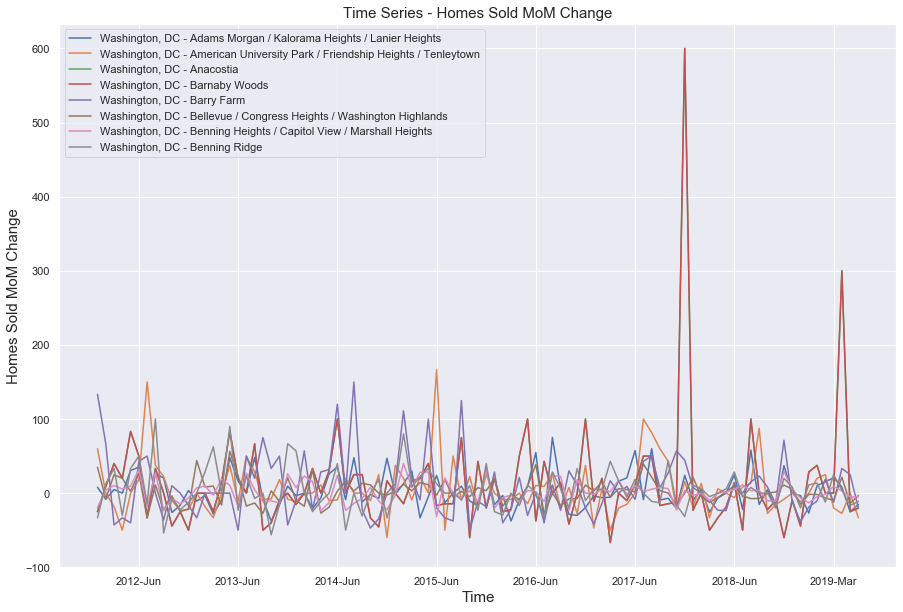

In [46]:
# plot 
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,1], label = df_temp.columns[1])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,2], label = df_temp.columns[2])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,3], label = df_temp.columns[3])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,4], label = df_temp.columns[4])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,5], label = df_temp.columns[5])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,6], label = df_temp.columns[6])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,7], label = df_temp.columns[7])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,8], label = df_temp.columns[8])


plt.legend()
plt.title("Time Series - Homes Sold MoM Change",fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Homes Sold MoM Change", fontsize = 15)
sns.set(rc={'figure.figsize':(15,10)})
plt.xticks(range(5, 100, 12))
#plt.xlim()
plt.show()
sns_plot.figure.savefig("Time Series - Homes Sold MoM Change.png")

In [47]:
# Find all regions with similar characteristic based on both Wilcoxon and Mann Whitney tests
index_wc = test_matrix_2['index_wctest'] == 1
index_mu = test_matrix_2['index_mutest'] == 1
#test_matrix[index_wc]
#test_matrix[index_mu]
temp = test_matrix_2[index_wc & index_mu]
temp[81:120]
#temp[121:160]

,combinatory,Stat_ttest,p_ttest,df_ttest,Stat_wctest,p_wctest,Stat_kstest,p_kstest,Stat_mutest,p_mutest,index_ttest,index_wctest,index_kstest,index_mutest
81,"(1, 2)",-0.663950,0.507668,161.659482,2170.0,0.952641,0.096774,0.776502,4244.0,0.827351,1,1,1,1
82,"(1, 3)",-1.192844,0.235493,110.182645,2148.5,0.887262,0.129032,0.421098,4360.5,0.922898,1,1,1,1
83,"(1, 4)",-1.163719,0.246409,148.092708,2020.0,0.525995,0.129032,0.421098,4248.0,0.835920,1,1,1,1
84,"(1, 5)",0.288538,0.773305,161.181218,2181.0,0.986243,0.139785,0.323565,4108.0,0.556246,1,1,1,1
85,"(1, 6)",0.450736,0.652822,152.027395,2111.5,0.776763,0.139785,0.323565,4142.5,0.621002,1,1,1,1
86,"(1, 7)",-0.406638,0.684757,179.878259,1951.0,0.368911,0.139785,0.323565,4146.0,0.627524,1,1,1,1
87,"(1, 8)",-0.988901,0.324598,126.574487,2071.5,0.662253,0.129032,0.421098,4326.0,0.997825,1,1,1,1
88,"(1, 9)",-1.155958,0.249558,148.225271,2027.5,0.544915,0.107527,0.655429,4269.0,0.880868,1,1,1,1
89,"(1, 10)",0.694844,0.488472,122.196216,2100.0,0.743212,0.215054,0.027108,4075.0,0.497575,1,1,0,1
90,"(1, 11)",0.442014,0.659125,147.686303,2147.5,0.884236,0.172043,0.127479,4108.0,0.556219,1,1,1,1


In [48]:
temp[121:160]

,combinatory,Stat_ttest,p_ttest,df_ttest,Stat_wctest,p_wctest,Stat_kstest,p_kstest,Stat_mutest,p_mutest,index_ttest,index_wctest,index_kstest,index_mutest
121,"(1, 42)",-0.179243,0.857953,176.063818,2127.5,0.824132,0.086022,0.881527,4342.0,0.963046,1,1,1,1
122,"(1, 43)",-0.663950,0.507668,161.659482,2170.0,0.952641,0.096774,0.776502,4244.0,0.827351,1,1,1,1
123,"(1, 44)",-0.794537,0.427989,170.313804,2096.5,0.733094,0.107527,0.655429,4165.5,0.665870,1,1,1,1
124,"(1, 45)",0.502217,0.616209,159.142462,2101.5,0.747563,0.161290,0.177833,4186.0,0.706979,1,1,1,1
125,"(1, 46)",-0.968813,0.334360,135.851667,2156.0,0.910005,0.182796,0.089415,4450.5,0.732397,1,1,1,1
126,"(1, 47)",-0.776020,0.439124,132.126023,2012.0,0.506187,0.096774,0.776502,4354.5,0.935913,1,1,1,1
127,"(1, 48)",-0.225451,0.821894,173.822814,2164.5,0.935868,0.107527,0.655429,4476.0,0.680774,1,1,1,1
128,"(1, 49)",0.298495,0.765690,169.702139,2094.0,0.725894,0.129032,0.421098,4193.5,0.722227,1,1,1,1
129,"(1, 50)",-0.233087,0.815954,182.831912,2131.0,0.834587,0.129032,0.421098,4120.0,0.578303,1,1,1,1
130,"(1, 51)",0.534299,0.593955,144.649923,2154.0,0.903932,0.182796,0.089415,4072.0,0.492329,1,1,1,1


#### Inventory MoM Hypothesis Tests

In [49]:
# C is the final dataset(panda.dataframe) with only inventory MoM for each region. Say n regions
# Create a list combine_list containing any two regions out of n region: list(itertools.combinations(range(A.shape[1]), 2))
# Run a loop to perform hypothesis testings: T test, Wilcoxon test, KS test, Mann-Whitney rank test 
import itertools
from statsmodels.stats.weightstats import ttest_ind as t_test
from scipy.stats import wilcoxon
from scipy.stats import ks_2samp 
from scipy.stats import mannwhitneyu
combine_list = list(itertools.combinations(range(C.shape[1]), 2))
#statistic, p-value, degree of freedom for two-sample t test
t_stat = []
p_val_t = []
df = []
# statistic and p-value for Wilcoxon test 
non_stat = []
p_val_wc = []
# statistic and p-value for KS test 
ks_stat = []
p_val_ks = []
# statistic and p-value for Mann-Whitney rank test  test 
mu_stat = []
p_val_mu = []
for i in range(len(combine_list)):
    temp1, temp2, temp3 = t_test(C.iloc[:,combine_list[i][0]], C.iloc[:,combine_list[i][1]], alternative = "two-sided", usevar = "unequal")
    t_stat.append(float(temp1)) 
    p_val_t.append(float(temp2))
    df.append(float(temp3))
    temp4, temp5 = wilcoxon(C.iloc[:,combine_list[i][0]], C.iloc[:,combine_list[i][1]], alternative = "two-sided", zero_method = "zsplit")
    non_stat.append(float(temp4))
    p_val_wc.append(float(temp5)) 
    temp6, temp7 = ks_2samp(C.iloc[:,combine_list[i][0]], C.iloc[:,combine_list[i][1]], alternative = "two-sided", mode = 'asymp')
    ks_stat.append(float(temp6))
    p_val_ks.append(float(temp7))
    temp8, temp9 = mannwhitneyu(C.iloc[:,combine_list[i][0]], C.iloc[:,combine_list[i][1]], alternative = "two-sided")
    mu_stat.append(float(temp8))
    p_val_mu.append(float(temp9))
test_matrix_3 = pd.DataFrame(list(zip(combine_list, t_stat, p_val_t, df, non_stat, p_val_wc, ks_stat, p_val_ks, mu_stat, p_val_mu)), 
               columns =['combinatory', 'Stat_ttest', 'p_ttest', 'df_ttest', 'Stat_wctest', 'p_wctest', 'Stat_kstest', 'p_kstest', 'Stat_mutest', 'p_mutest'])

In [50]:
test_matrix_3

,combinatory,Stat_ttest,p_ttest,df_ttest,Stat_wctest,p_wctest,Stat_kstest,p_kstest,Stat_mutest,p_mutest
0,"(0, 1)",-0.643420,0.520900,155.402703,2146.5,0.881213,0.150538,0.242640,4445.5,0.742701
1,"(0, 2)",-0.491520,0.623709,165.862372,1992.5,0.459603,0.118280,0.533508,4376.5,0.888330
2,"(0, 3)",NaN,NaN,NaN,1829.0,0.171950,0.258065,0.004085,4103.0,0.546987
3,"(0, 4)",-0.513347,0.608559,133.225851,2125.5,0.818172,0.139785,0.323565,4550.5,0.539014
4,"(0, 5)",0.465767,0.642011,161.160468,2066.0,0.647040,0.129032,0.421098,4418.5,0.798953
...,...,...,...,...,...,...,...,...,...,...
3316,"(78, 80)",-0.796699,0.426871,151.696854,2071.5,0.662253,0.193548,0.061375,4266.0,0.874395
3317,"(78, 81)",0.158545,0.874206,179.316750,2172.5,0.960273,0.118280,0.533508,4397.5,0.843377
3318,"(79, 80)",-0.583770,0.560146,170.514204,2035.0,0.564170,0.139785,0.323565,4222.0,0.781010
3319,"(79, 81)",0.361701,0.718043,163.223351,2161.0,0.925209,0.150538,0.242640,4269.0,0.880852


In [51]:
test_matrix_3['p_ttest'][0]

0.5209002558020271

In [52]:
# Create a function to detect the hypothesis testing results. 0: reject null, 1: fail to reject null

def test_p_value_3(p = .05, name = 'ttest'):
    name_list = []
    for i in range(len(test_matrix_3)):
        if test_matrix_3["p_" + name][i] < p:
            name_list.append(0) 
        else:
            name_list.append(1)   
    test_matrix_3['index_' + name] = name_list
test_p_value_3(p = .05, name = 'ttest')
test_p_value_3(p = .05, name = 'wctest')
test_p_value_3(p = .05, name = 'kstest')
test_p_value_3(p = .05, name = 'mutest')
test_matrix_3
test_matrix_3.to_csv('data/TM_Inventory MoM.csv')

In [ ]:
time_frame = pd.date_range('2012-02-01','2019-10-01', 
              freq='MS').strftime("%Y-%b").tolist()
df_temp = pd.DataFrame(list(zip(time_frame, B['Homes Sold MoM _1'], B['Homes Sold MoM _2'], B['Homes Sold MoM _3'], B['Homes Sold MoM _3'], B['Homes Sold MoM _4'], B['Homes Sold MoM _5'], B['Homes Sold MoM _6'],B['Homes Sold MoM _7'])), 
               columns =['Time', df_list[0]['Region_0'][0], df_list[1]['Region_1'][0], df_list[2]['Region_2'][0], df_list[3]['Region_3'][0], df_list[4]['Region_4'][0], df_list[5]['Region_5'][0], df_list[6]['Region_6'][0], df_list[7]['Region_7'][0]])

In [ ]:
# plot 
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,1], label = df_temp.columns[1])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,2], label = df_temp.columns[2])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,3], label = df_temp.columns[3])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,4], label = df_temp.columns[4])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,5], label = df_temp.columns[5])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,6], label = df_temp.columns[6])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,7], label = df_temp.columns[7])
sns_plot = sns.lineplot(df_temp['Time'], df_temp.iloc[:,8], label = df_temp.columns[8])


plt.legend()
plt.title("Time Series - Homes Sold MoM Change",fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Homes Sold MoM Change", fontsize = 15)
sns.set(rc={'figure.figsize':(15,10)})
plt.xticks(range(5, 100, 12))
#plt.xlim()
plt.show()
sns_plot.figure.savefig("Time Series - Homes Sold MoM Change.png")